# Introduction to sqlite and SQL  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io import sql
import sqlite3

/Users/michaeltwardos/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Setup

In [2]:
#The data has information about when users for fictional company signed up and other metadata about them.
users = pd.read_csv('users.csv', low_memory=False)
users.head()

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,3861,1338425007,ORG_INVITE,0,0,115,3861
1,11430,1338428551,ORG_INVITE,0,0,239,5677
2,7170,1338445431,ORG_INVITE,0,0,145,7170
3,10012,1338452406,ORG_INVITE,0,1,225,7104
4,11999,1338465359,PERSONAL_PROJECTS,0,0,6,NULL


In [3]:
conn = sqlite3.connect('lesson-16.db', detect_types=sqlite3.PARSE_DECLTYPES)

In [4]:
#Put data into the eliflo DB
users.to_sql('users',
            con=conn,
            if_exists='replace',
            index=False)

### Count, Sum, Average

In [11]:
#Our first query in python sqlite!  What does * mean?
#Who knows the HelloWorld of SQL?
a=sql.read_sql('''
select * from users limit 1;
''', con=conn)
a
#Question - Given a new data set in SQL, what are ways you start categorizing a data set?  
#What is the equivalent of df.describe?

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,3861,1338425007,ORG_INVITE,0,0,115,3861


In [8]:
#See what tables currently exist in your database.
a=sql.read_sql('''
SELECT name FROM sqlite_master WHERE type = "table";
''', con=conn)
a

,name
0,lesson-16
1,master_fact
2,users


In [12]:
#Examples of count, sum and average functions
a=sql.read_sql('''
select  
    count(*)  as num_of_rows,
    count(distinct(customerid))  as distinct_customers,
    sum(mailinglist) as num_mailing,
    avg(mailinglist) as mailing_probability
from 
    users ;
''', con=conn)
a

,num_of_rows,distinct_customers,num_mailing,mailing_probability
0,10000,10000,2486,0.2486


How many distinct users (parentid) invited a customer?

In [13]:
#Examples of count, sum and average functions
a=sql.read_sql('''
select  
    count(distinct(parentid))  as distinct_customers
from 
    users ;
''', con=conn)
a

,distinct_customers
0,2360


### Min, Max

In [14]:
#use min, max and date to compute date range.
#Date functionality is very useful.
a=sql.read_sql('''
select  
    date(min(datecreated), 'unixepoch') as start_date, 
    date(max(datecreated), 'unixepoch') as end_date
from 
    users ;
''', con=conn)
a

,start_date,end_date
0,2012-05-31,2014-03-19


### Case

In [16]:
#Example of using case 
a=sql.read_sql('''
select  
    sum(case when mailinglist = 1 then 1 else 0 end) as mailing_true,
    sum(case when mailinglist = 0 then 1 else 0 end) as mailing_false,
    sum(case when mailinglist not in (0, 1) then 1 else 0 end) as mailing_other
from 
    users ;
''', con=conn)
a

,mailing_true,mailing_false,mailing_other
0,2486,7514,0


Use case to measure how many customers were invited by someone

In [26]:
#Example of using case 
a=sql.read_sql('''
select  
    sum(case when parentid > 0 then 1 else 0 end) as invited
from 
    users ;
''', con=conn)
a

,invited
0,5334


### Group By

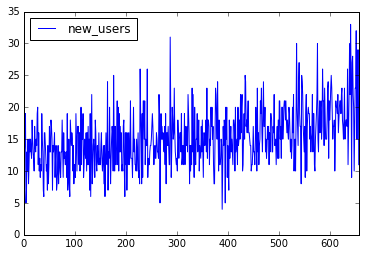

In [19]:
#Show signups per day
a=sql.read_sql('''
select 
    date(datecreated, 'unixepoch') as day_created, 
    count(*) as new_users 
from 
    users 
group by 1
''', con=conn)
a.plot()

How many users came through each source?

In [20]:
#What are the most popular sources that users came from?
a=sql.read_sql('''
select 
    source, 
    count(*) as new_users 
from 
    users 
group by 1 
order by 2 desc;
''', con=conn)
a

,source,new_users
0,ORG_INVITE,3535
1,GUEST_INVITE,1799
2,PERSONAL_PROJECTS,1790
3,SIGNUP,1735
4,SIGNUP_GOOGLE_AUTH,1141


### Modulo

In [21]:
#Bucketing users.  Good for experiments!
a=sql.read_sql('''
select 
    customerid % 4, 
    count(*) as new_users 
from 
    users 
group by 1
''', con=conn)
a

,customerid % 4,new_users
0,0,2493
1,1,2524
2,2,2464
3,3,2519


# Growth Analytics with Master Fact 

In [22]:
#Get data about these users subsequent activity
activity = pd.read_csv('activity.csv', low_memory=False)
activity.head()

,customerid,timestamp,eventtype
0,10012,1338452406,login
1,3428,1338479256,login
2,9899,1338484777,login
3,1693,1338501513,login
4,6102,1338509850,login


In [23]:
#Convert activity to sqlite
activity.to_sql('master_fact',
            con=conn,
            if_exists='replace',
            index=False)

### Subquery

In [24]:
#Example of a subquery
a=sql.read_sql('''
select
visits,
count(distinct(customerid)) as customers
from
(
select
    customerid,
    count(*) as visits
from
    master_fact
where
    eventtype = 'login'
group by 1 
) q
group by 1 
order by 2 desc;
    ''', con=conn)
a.head(5)
               

,visits,customers
0,1,5178
1,2,279
2,3,193
3,4,155
4,5,78


### Join Example

In [ ]:
Give me the users that were active on '2014-01-01' that were also active on '2014-01-07'.

In [ ]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select
    count(distinct(b.customerid)) as returning_users
from
    master_fact a
left join
    master_fact b
on
    a.customerid = b.customerid
where
    substr(date(a.timestamp, 'unixepoch'), 1,10)='2014-01-01' and
    substr(date(b.timestamp, 'unixepoch'), 1,10)='2014-01-07'
    ''', con=conn)
a.head(10)

### Measuring a Growth Susceptibility: Retention Rate

In [28]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select 
    a.month_created,
    cast(returning_users as real)/new_users
from
(
select
    substr(date(datecreated, 'unixepoch'), 1,7) as month_created,
    count(distinct(customerid)) as new_users
from
    users 
group by 1
) a
left join
(
select
    substr(date(a.datecreated, 'unixepoch'), 1,7) as month_created,
    count(distinct(b.customerid)) as returning_users
from
    users a
left join
    master_fact b
on
    a.customerid = b.customerid
where
    b.timestamp between a.datecreated + 7*86400 and a.datecreated + 14*86400
group by 1
) b
on a.month_created = b.month_created
    ''', con=conn)
a.head(10)

,month_created,cast(returning_users as real)/new_users
0,2012-05,0.187500
1,2012-06,0.114713
2,2012-07,0.103359
3,2012-08,0.109589
4,2012-09,0.085575
5,2012-10,0.089776
6,2012-11,0.091133
7,2012-12,0.101942
8,2013-01,0.109620
9,2013-02,0.115479


In [ ]:
#This query looks at the retention rate for a selected cohort.
a=sql.read_sql('''
select 
    month as age_in_months,
    cast(returning_users as real)/initial_cohort as retention_rate
from
(select
   cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
    count(distinct(b.customerid)) as returning_users
from
    users a
left join
    master_fact b
on
    a.customerid = b.customerid
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' and
    cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
group by 1) a,
(select
    count(distinct(customerid)) as initial_cohort
from
    users a
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' 
)
    ''', con=conn)
a.head(5)

In [ ]:
#Generalizing the calculation of a retention curve
def constructRetentionCurve(month):
    string = '''
    select 
        month,
        cast(returning_users as real)/initial_cohort as retention_rate
    from
    (select
        cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
        count(distinct(b.customerid)) as returning_users
    from
        users a
    left join
        master_fact b
    on
        a.customerid = b.customerid
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s' and
        cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
    group by 1) a,
    (select
        count(distinct(customerid)) as initial_cohort
    from
        users a
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s'  
    )
    ''' % (month, month)
    return string

In [ ]:
a=sql.read_sql(constructRetentionCurve('2012-10'), con=conn)
b=sql.read_sql(constructRetentionCurve('2012-06'), con=conn)
#How do we join the retention curves together?

In [ ]:
# A function to simulate linear susceptibility.
def linearG(t, b, m):
    if t < 0:
        return 0
    if t == 0:
        return 0.75
    elif b - m*t  > 0:
        return round(b -m*t, 3)
    else:
        return 0

In [ ]:
plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
plt.rc('lines', linewidth=3)
plt.plot([item for item in a['month']] ,[item for item in a['retention_rate']]) 
plt.plot([item for item in b['month']] ,[item for item in b['retention_rate']]) 
#Compare these measurements to a functional form.
#plt.plot([item for item in range(30)] ,[linearG(item, 0.15, 0.002) for item in range(30)]) 
plt.xlabel('Age (ty - tx)')
plt.ylabel('P(y)')
plt.ylim((0,1))
plt.show()

### Use susceptibility to do projections

In [ ]:
def computeYLin(cohorts, daysOut, b, m):
    currentDay = len(cohorts)
    Y = []
    #First Calculate DAU while cohorts are being acquired
    for t in range(currentDay):
        actives=[]
        for i in range(t):
            actives.append(round(cohorts[t-i]*linearG(i, b, m), 3))
        Y.append(sum(actives))
    #Now calculate more DAU as we project out after acquiring cohorts
    for t in range(daysOut):
        actives=[]
        for i in range(currentDay):
            actives.append(round(cohorts[currentDay-i-1]*linearG(t+i-1, b, m), 3))
        Y.append(sum(actives))
    return Y 

In [ ]:
#Show signups per day
new_users=sql.read_sql('''
select 
    substr(date(datecreated, 'unixepoch'), 1,7) as month_created, 
    count(*) as new_users 
from 
    users 
group by 1
''', con=conn)
plt.figure(figsize=(6,4))
plt.style.use('seaborn-whitegrid')
plt.xlabel('time (months)')
plt.ylabel('New Users')
plt.plot(new_users['new_users'])

In [ ]:
#Show active users per day
dau=sql.read_sql('''
select 
    substr(date(timestamp, 'unixepoch'), 1,7) as month_active, 
    count(distinct(customerid)) as active_users 
from 
    master_fact
group by 1
''', con=conn)
plt.figure(figsize=(6,4))
plt.style.use('seaborn-whitegrid')
plt.xlabel('time (months)')
plt.ylabel('DAU')
plt.plot(dau['active_users'])


In [ ]:
cohorts = [item for item in new_users['new_users']]
results=pd.DataFrame(computeYLin(cohorts, 1, 0.15, 0.002))
#Project out further
#results=pd.DataFrame(computeYLin(cohorts, 1, 0.15, 0.002))
plt.figure(figsize=(6,4))
plt.style.use('seaborn-whitegrid')
plt.xlabel('time (months)')
plt.ylabel('DAU')
plt.plot(dau['active_users'])
plt.plot(results)
#What if we half the rate of decay and increase the initial intercept?
#results2=pd.DataFrame(computeYLin(cohorts, 1, 0.2, 0.001))
#plt.plot(results2)

plt.show()

# Building a Churn Prediction Model

#### Write a query that uses the number of logins a customer performs in the first 30 days  (as well as other metadata such as source, mailinglist) to determine whether a customer will be active in  their fourth month (days 90 through 120).

In [29]:
#A solution....
a=sql.read_sql('''

select
    x.customerid,
    source,
    mailinglist,
    testgroup,
    logins,
    case when return_visits > 0 then 1 else 0 end  as retained
from
(select
    a.customerid,
    source,
    mailinglist,
    testgroup,
    count(*) as logins
from
    users a
left join
    master_fact b
on
    a.customerid = b.customerid
where
    (b.timestamp - a.datecreated) < (86400*30)  
group by 1) x
left join
(select
    a.customerid,
    count(*) as return_visits
from
    users a
left join
    master_fact b
on
    a.customerid = b.customerid
where
    (b.timestamp - a.datecreated) between  (86400*90) and (86400*120)  
group by 1) y
on
    x.customerid = y.customerid


    ''', con=conn)
a.head(5)

,customerid,source,mailinglist,testgroup,logins,retained
0,2,ORG_INVITE,0,0,3,1
1,3,ORG_INVITE,0,0,1,0
2,4,GUEST_INVITE,0,0,1,0
3,5,GUEST_INVITE,0,0,1,0
4,6,GUEST_INVITE,0,0,1,0


In [30]:
creation_source = pd.get_dummies(a['source'])
modelData = pd.concat([a, creation_source], axis=1)    
del modelData['source']
modelData.head()

,customerid,mailinglist,testgroup,logins,retained,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,2,0,0,3,1,0,1,0,0,0
1,3,0,0,1,0,0,1,0,0,0
2,4,0,0,1,0,1,0,0,0,0
3,5,0,0,1,0,1,0,0,0,0
4,6,0,0,1,0,1,0,0,0,0


In [31]:
modelData.corr()['retained']

customerid              0.000903
mailinglist             0.005215
testgroup              -0.000956
logins                  0.499281
retained                1.000000
 GUEST_INVITE           0.050877
 ORG_INVITE            -0.014247
 PERSONAL_PROJECTS      0.026236
 SIGNUP                -0.041771
 SIGNUP_GOOGLE_AUTH    -0.008303
Name: retained, dtype: float64

In [32]:
feature_cols = ['mailinglist', 'testgroup', 'logins', ' GUEST_INVITE       ',' ORG_INVITE         ', ' PERSONAL_PROJECTS  ' ]
X=modelData[feature_cols]
y=modelData.retained

In [33]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(random_state=1)
# Train model
tree.fit(X, y)
important = tree.feature_importances_
for i in range(len(feature_cols)):
    print feature_cols[i], round(important[i], 2)


mailinglist 0.01
testgroup 0.01
logins 0.95
 GUEST_INVITE        0.01
 ORG_INVITE          0.01
 PERSONAL_PROJECTS   0.01


In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [35]:
from sklearn import metrics

print "Decision Tree : " , metrics.mean_squared_error(y, tree.predict(X))
print "Logistic Regression : " , metrics.mean_squared_error(y, logreg.predict(X))

Decision Tree :  0.135583991288
Logistic Regression :  0.142934930574
